# Slightly compressible flow
In this tutorial we investigate how to use PorePy to solve slighlty compresible flow. <br>


**Note**: This tutorial will focus on a 2d domain, however most of the code works for 1d, 2d, and 3d domains.<br>

Let is $\Omega$ a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written in primal formulation as:

$$ \phi\frac{\partial\rho}{\partial t}- \nabla \cdot \rho K \nabla p = \rho f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Where $\phi$ is the porosity, $\rho$ is the fluid density, $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_b$ is the flux at the boundary (Neumann condition).<br>

As a relationship between pressure and density we use $c_p\rho = \text{d}\rho/\text{d}p$. Assuming slightly compressible flow (e.g., $\nabla\rho\cdot K\nabla p \ll 1$) we can write conservation of mass as

$$c_p\phi\frac{\partial p}{\partial t} - \nabla \cdot K \nabla p = f $$

We now discretize in time using backward Euler and time step $k$:
$$c_p\phi\frac{p^{k+1} - p^k}{k} - \nabla \cdot K \nabla p^{k+1} = f^{k+1} $$


# Import modules

First we have to import the modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import porepy as pp

# Define problem setup:
We define our problem in the unit square. We let our data inherit from the compressible data assigner base class to set default values. We set different parameters in the matrix and fractures. For the matrix we use use default parameters for everything except the initial pressure. Note that we let the Fracture data inherit from the matrix data. In this way, the initial pressure (or any other parameters you may set for the matrix) is equal the parameter for the matrix unless it is overloaded in the fracture data class.

In [2]:
class MatrixDomain(pp.SlightlyCompressibleDataAssigner):
    def initial_pressure(self):
        return np.ones(self.grid().num_cells)

class FractureDomain(MatrixDomain):
    def permeability(self):
        kxx = 1000 * np.ones(self.grid().num_cells)
        return pp.SecondOrderTensor(2, kxx)
    
    def aperture(self):
        return np.power(0.001, 2 - self.grid().dim)

class IntersectionDomain(FractureDomain):
    def source(self, t):
        assert self.grid().num_cells == 1, 'Assumes Intersection domain only has 1 cell'
        f = .4 * self.grid().cell_volumes  # m**3/s
        return f * (t < .05)


We are now ready to create the grid bucket and assign data to it. The important thing to notice is that the data classes should be stored with the keyword 'flow_data' (or more general, solver.physics + '_data').

In [3]:
# generate grid bucket
nx = 12
ny = 12
frac1 = np.array([[0, 1], [.5, .5]])
frac2 = np.array([[.5, .5], [0, 1]])
fracs = [frac1, frac2]
physdims = [1, 1]
gb = pp.meshing.cart_grid(fracs, [nx, ny], physdims=physdims)

# Initate data
for g, d in gb:
    if g.dim == 2:
        d['flow_data'] = MatrixDomain(g, d)
    elif g.dim == 1:
        d['flow_data'] = FractureDomain(g, d)
    elif g.dim == 0:
        d['flow_data'] = IntersectionDomain(g, d)
    else:
        raise ValueError('Unkown grid-dimension %d' %g.dim)
# Set time stepping parameters:
dt = .005
T = 0.1

We now initialize the model, and an implicit time stepper to solve it:

In [4]:
model = pp.SlightlyCompressibleModel(gb)
time_stepper = pp.Implicit(model, dt=dt)
t = 0
while t < T + 1e-7:
    t += dt
    model.update(t)         # Updates source term 
    time_stepper.update()   # sets p_k = p_k+1
    time_stepper.assemble() # Reassembles the left and right hand side
    time_stepper.step()     # Solve lhs * x = rhs


And we can plot the pressure field at the end time

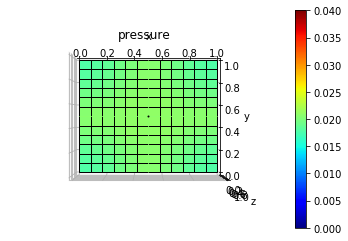

In [5]:
model.pressure(time_stepper.x, 'pressure')
pp.plot_grid(model.grid(), 'pressure', color_map = [0, 0.04], if_plot=False)
plt.title('pressure')
plt.show()

The pressure increases in the whole domain until the shutin of the well at $t=0.05$ s, and after this the pressure eavens out. Because the fractures are more permeable than the matrix, the fluid will tend to flow out along the fractures instead of in the matrix. 

The time evolution of the pressure filed looks like:

In [6]:
from IPython.display import HTML
HTML('<img src="fig/slightly_compressible.gif">')